In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import fmin
from mpmath import gammainc
import powerlaw

In [2]:
from scipy import special

In [3]:
data=np.loadtxt('waitingtimes.txt')
#data=np.loadtxt('contactdurations2.txt')
#data=np.loadtxt('weights2s9.txt')

In [4]:
len(data),np.min(data),np.max(data)

(145802, 1.0, 3040.0)

# Set data range

In [5]:
fit = powerlaw.Fit(data)
fit.power_law.alpha,fit.power_law.xmin

Calculating best minimal value for power law fit
/opt/anaconda3/envs/phdenv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


(1.9428700371300325, 6.0)

In [6]:
a = fit.power_law.xmin #np.min(data) #

In [7]:
a

6.0

# Maximum Likelihood Estimates

In [8]:
# exponential
def likelihood_exp(x, xmin=None):
    if not xmin:
        a = np.min(x)
    else:
        a = xmin
        x = x[x >= a]
    # maximum likelihood estimate
    MLE = 1/(np.mean(x) - a)
    return MLE

In [9]:
# Truncated Levy flight
def likelihood_tlf(params, x, xmin):
    alpha, Lambda = params
    if alpha < 1  or Lambda < 0:
        
        return np.tile(10 ** (-300), len(x))#float_info.min_10_exp
    
    likelihoods = (Lambda ** (1 - alpha)) /\
    ((x ** alpha) * np.exp(Lambda * x) * float(gammainc(1 - alpha, Lambda * xmin)))
    
    likelihoods[likelihoods == 0] = 10 ** (-300)#float_info.min_10_exp
    return likelihoods

In [10]:
# Stretched exponential
def likelihood_stexp(params, x, xmin):
    lambd, beta = params
    # Clauset et al. (2007) form
    likelihoods = x**(beta-1) * beta * lambd * np.exp(lambd*xmin**beta - lambd*x**beta)
    return likelihoods

In [11]:
# Log-normal
def lklhood_lognormal(params, x):
    mu, sigma = params
    return np.exp(-((np.log(x)-mu)**2)/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma*x)

# Log-likelihoods

In [12]:
def loglikelihood_exp(x, lambd, xmin):
    return len(x) * np.log(lambd) + len(x) * lambd * xmin - lambd * np.sum(x)

In [13]:
def loglikelihood_TLF(x, alpha, lambd, xmin):
    C = lambd**(1-alpha) / float(gammainc(1-alpha,lambd*xmin))
    return len(x) * np.log(C) - alpha * np.sum(np.log(x)) - lambd * np.sum(x)

In [14]:
def loglikelihood_stexp(x, lambd, beta, xmin):
    # Clauset et al. (2007) form
    likelihood = x**(beta-1) * beta * lambd * np.exp(lambd*xmin**beta - lambd*x**beta)
    
    return np.sum(np.log(likelihood))

In [15]:
def loglikelihood_lnorm(x, mu, sigma):
    likelihood = np.exp(-((np.log(x)-mu)**2)/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma*x)
    return np.sum(np.log(likelihood))

# Akaike model selection

In [16]:
# Compare exponential, truncated Levy flight, stretched exponential, and log-normal
def akaikeWeights_v1(data, xmin=None):
    
    # prepare data
    if not xmin:
        a = np.min(data)
    else:
        a = xmin
        
    x = data[data >= a]
    
    # Maximum likelihood estimates ###############################
    
    MLEs = []
    
    # exponential
    lambda_exp = likelihood_exp(x, a)
    print('Exponential MLE:', lambda_exp)
    MLEs.append(lambda_exp)
    
    # Truncated Levy flight
    init_vals = [2,lambda_exp]
    parameters = fmin(lambda p: -np.sum(np.log(likelihood_tlf(p,x,a))), init_vals)
    alpha, lambda_tlf = parameters
    print('Truncated Levy flight MLEs:', alpha, lambda_tlf)
    MLEs.append(alpha)
    MLEs.append(lambda_tlf)
        
    # Stretched exponential
    init_vals = [lambda_exp,1.]
    parameters = fmin(lambda p: -np.sum(np.log(likelihood_stexp(p,x,a))), init_vals, disp=False)
    lambda_se, beta_se = parameters
    print('Stretched exponential MLEs:', lambda_se, beta_se)
    MLEs.append(lambda_se)
    MLEs.append(beta_se)
    
    # Log-normal
    init_vals = [1,2]
    parameters = fmin(lambda p: -np.sum(np.log(lklhood_lognormal(p,x))), init_vals)
    mu_lnorm, sigma_lnorm = parameters
    print('Log-normal MLEs:', mu_lnorm, sigma_lnorm)
    MLEs.append(mu_lnorm)
    MLEs.append(sigma_lnorm)
    
    # Log-likelihood values ######################################
    
    # exponential
    loglikelihood = loglikelihood_exp(x, lambda_exp, xmin=a)
    print(loglikelihood)
    AIC1 = -2 * loglikelihood + 2
    
    # truncated power-law
    loglikelihood = loglikelihood_TLF(x, alpha, lambda_tlf, xmin=a)
    print(loglikelihood)
    AIC2 = -2 * loglikelihood + 4
    
    # stretched exponential
    loglikelihood = loglikelihood_stexp(x, lambda_se, beta_se, xmin=a)
    print(loglikelihood)
    AIC3 = -2 * loglikelihood + 4
    
    # log-normal
    loglikelihood = loglikelihood_lnorm(x, mu_lnorm, sigma_lnorm)
    print(loglikelihood)
    AIC4 = -2 * loglikelihood + 4
    
    
    # AIC differences
    
    AICs = [AIC1,AIC2,AIC3, AIC4]
    
    AICmin = np.argmin(AICs) + 1
    
    if AICmin == 1:
        Delta1 = 0
        Delta2 = AIC2 - AIC1
        Delta3 = AIC3 - AIC1
        Delta4 = AIC4 - AIC1
    elif AICmin == 2:
        Delta1 = AIC1 - AIC2
        Delta2 = 0
        Delta3 = AIC3 - AIC2
        Delta4 = AIC4 - AIC2
    elif AICmin == 3:
        Delta1 = AIC1 - AIC3
        Delta2 = AIC2 - AIC3
        Delta3 = 0
        Delta4 = AIC4 - AIC3
    elif AICmin == 4:
        Delta1 = AIC1 - AIC4
        Delta2 = AIC2 - AIC4
        Delta3 = AIC3 - AIC4
        Delta4 = 0
        
    print("AIC differences:", Delta1, Delta2, Delta3, Delta4)
    
    # Akaike weights
    w1 = np.exp(-Delta1/2) / (np.exp(-Delta1/2) + np.exp(-Delta2/2)\
                              + np.exp(-Delta3/2) + np.exp(-Delta4/2))
    w2 = np.exp(-Delta2/2) / (np.exp(-Delta1/2) + np.exp(-Delta2/2)\
                              + np.exp(-Delta3/2) + np.exp(-Delta4/2))
    w3 = np.exp(-Delta3/2) / (np.exp(-Delta1/2) + np.exp(-Delta2/2)\
                              + np.exp(-Delta3/2) + np.exp(-Delta4/2))
    w4 = np.exp(-Delta4/2) / (np.exp(-Delta1/2) + np.exp(-Delta2/2)\
                              + np.exp(-Delta3/2) + np.exp(-Delta4/2))
    return w1, w2, w3, w4, MLEs

In [17]:
w1, w2, w3, w4, parameters = akaikeWeights_v1(data,xmin=a)
print("w_exp:", w1)
print("w_tlf:", w2)
print("w_se:",  w3)
print("w_lnorm:",  w4)

Exponential MLE: 0.02812353694419382
Optimization terminated successfully.
         Current function value: 177261.880809
         Iterations: 49
         Function evaluations: 95
Truncated Levy flight MLEs: 1.8935838380637877 0.0003892773309285678
Stretched exponential MLEs: 108.02130430906092 0.008515235051005186
Optimization terminated successfully.
         Current function value: 196384.533632
         Iterations: 43
         Function evaluations: 80
Log-normal MLEs: 2.8523198046479195 1.060607384475595
-207315.29517993727
-177261.88080897814
-177385.15084959308
-196384.53363234582
AIC differences: 60104.82874191826 0 246.5400812298758 38245.30564673536
w_exp: 0.0
w_tlf: 1.0
w_se: 2.914080715909327e-54
w_lnorm: 0.0


## Data pdf

In [18]:
def datapdf(data, xmin=None):
    # Code copied from powerlaw package:
    # https://github.com/jeffalstott/powerlaw/blob/master/powerlaw.py
    data = np.asarray(data)
    xmax = np.max(data)
    if not xmin:
        xmin = np.min(data)

    if xmin<1:  
        xmax2=xmax/xmin
        xmin2=1
    else:
        xmax2=xmax
        xmin2=xmin

    log_min_size = np.log10(xmin2)
    log_max_size = np.log10(xmax2)
    number_of_bins = int(np.ceil((log_max_size-log_min_size)*10))
    bins=np.unique(
            np.floor(
                np.logspace(
                    log_min_size, log_max_size, num=number_of_bins)))

    if xmin<1: #Needed to include also data x<1 in pdf.
        hist, edges = np.histogram(data/xmin, bins, density=True)
        edges=edges*xmin # transform result back to original
        hist=hist/xmin # rescale hist, so that np.sum(hist*edges)==1
    else:
        hist, edges = np.histogram(data, bins, density=True)
        
    bin_centers = (edges[1:]+edges[:-1])/2.0
    return bin_centers, hist

## Fits

In [19]:
x = np.sort(data[data >= a]) # [data >= a]

In [20]:
# Exponential, truncated Levy flight, stretched exponential, and log-normal
lambda_exp, alpha, lambda_tlf, lambda_se, beta_se, mu_lnorm, sigma_lnorm = parameters

In [21]:
# Exponential
exp = lambda_exp * np.exp(-lambda_exp * (x - a))

In [22]:
# TLF
C = lambda_tlf**(1-alpha) / float(gammainc(1-alpha,lambda_tlf*a))
tlf = C * x**(-alpha) * np.exp(-lambda_tlf*x)

In [23]:
# Stretched exponential
stexp = x**(beta_se-1) * beta_se * lambda_se * np.exp(lambda_se*a**beta_se - lambda_se*x**beta_se)

In [24]:
# Log-normal
lnorm = np.exp(-((np.log(x)-mu_lnorm)**2)/(2*sigma_lnorm**2))/(np.sqrt(2*np.pi)*sigma_lnorm*x)

In [25]:
bin_centers, hist = datapdf(data,a)

# Plots

## Waiting times

In [26]:
bin_centers*=10
x*=10

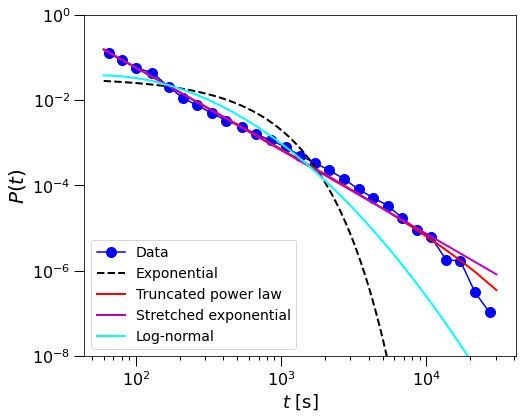

In [27]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,top=0.95,bottom=0.16)

plt.loglog(bin_centers, hist, color='b', marker='o',markersize=10, label='Data') # fillstyle='none',

plt.loglog(x, exp, color='k', linestyle='--', linewidth=2, label='Exponential')
plt.loglog(x, tlf, color='r', linewidth=2, label='Truncated power law')
plt.loglog(x, stexp, color='m', linewidth=2, label='Stretched exponential')
plt.loglog(x, lnorm, color='cyan', linewidth=2, label='Log-normal')

plt.xlabel(r'$t$' + ' [s]', fontsize=18)
plt.ylabel(r'$P(t)$', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tick_params(axis='both',length=10,width=1,which='major')
plt.tick_params(axis='both',length=4,width=1,which='minor')
plt.ylim([10e-9, 1])

plt.legend(loc=3,fontsize=14)

#plt.savefig('Figure02.eps')

plt.show()

# Confidence intervals

## Truncated power law

In [28]:
alpha, lambda_tlf

(1.8935838380637877, 0.0003892773309285678)

In [29]:
paramrange = np.arange(alpha - 0.01, alpha + 0.01, 0.00001)
R = []
init_vals = [2,lambda_exp]
p2 = -loglikelihood_TLF(x, alpha, lambda_tlf, xmin=a)
for alph in paramrange:
    
    p1 = -loglikelihood_TLF(x, alph, lambda_tlf, xmin=a)
    
    loglikelihood_ratio = p1 - p2

    R.append(loglikelihood_ratio)

In [30]:
R = np.asarray(R)
CI1 = paramrange[np.where(R <= 1.92)[0]][0]
CI2 = paramrange[np.where(R <= 1.92)[0]][-1]
CI1,CI2

(1.8835838380637877, 1.8935938380638533)

## Exponential

In [31]:
paramrange = np.arange(lambda_exp - 0.001,lambda_exp + 0.001,0.000001)
R = []
p2 = -loglikelihood_exp(x, lambda_exp, xmin=a)
for lambd in paramrange:

    p1 = -loglikelihood_exp(x, lambd, xmin=a)
        
    loglikelihood_ratio = p1 - p2

    R.append(loglikelihood_ratio)

In [32]:
R = np.asarray(R)
CI1 = paramrange[np.where(R <= 1.92)[0]][0]
CI2 = paramrange[np.where(R <= 1.92)[0]][-1]
CI1, lambda_exp, CI2

(0.02712353694419382, 0.02812353694419382, 0.02812353694419482)

## Stretched exponential

In [33]:
paramrange = np.arange(lambda_se - 0.01, lambda_se + 0.01, 0.00001)
R = []
p2 = -loglikelihood_stexp(x, lambda_se, beta_se, xmin=a)
for lambd in paramrange:
    
    p1 = -loglikelihood_stexp(x, lambd, beta_se, xmin=a)
    
    loglikelihood_ratio = p1 - p2

    R.append(loglikelihood_ratio)

In [34]:
R = np.asarray(R)
CI1 = paramrange[np.where(R <= 1.92)[0]][0]
CI2 = paramrange[np.where(R <= 1.92)[0]][-1]
CI1, lambda_se, CI2

(108.01130430906092, 108.02130430906092, 108.02338430906475)

In [35]:
paramrange = np.arange(beta_se - 0.01, beta_se + 0.01, 0.0001)
R = []
p2 = -loglikelihood_stexp(x, lambda_se, beta_se, xmin=a)
for bet in paramrange:
    
    p1 = -loglikelihood_stexp(x, lambda_se, bet, xmin=a)
    
    loglikelihood_ratio = p1 - p2

    R.append(loglikelihood_ratio)

<ipython-input-14-8a4c058723d4>:5: RuntimeWarning: invalid value encountered in log
  return np.sum(np.log(likelihood))


In [36]:
R = np.asarray(R)
CI1 = paramrange[np.where(R <= 1.92)[0]][0]
CI2 = paramrange[np.where(R <= 1.92)[0]][-1]
CI1, beta_se, CI2

(0.0005152350510051864, 0.008515235051005186, 0.00851523505100519)

## Log-normal

In [222]:
paramrange = np.arange(mu_lnorm - 0.01, mu_lnorm + 0.01, 0.00001)
R = []
p2 = -loglikelihood_lnorm(x, mu_lnorm, sigma_lnorm)
for mu in paramrange:
    
    p1 = -loglikelihood_lnorm(x, mu, sigma_lnorm)
    
    loglikelihood_ratio = p1 - p2

    R.append(loglikelihood_ratio)

In [223]:
R = np.asarray(R)
CI1 = paramrange[np.where(R <= 1.92)[0]][0]
CI2 = paramrange[np.where(R <= 1.92)[0]][-1]
CI1, mu_lnorm, CI2

(2.8425998046479215, 2.8523198046479195, 2.8621098046480493)

In [224]:
paramrange = np.arange(sigma_lnorm - 0.01, sigma_lnorm + 0.01, 0.00001)
R = []
p2 = -loglikelihood_lnorm(x, mu_lnorm, sigma_lnorm)
for sig in paramrange:
    
    p1 = -loglikelihood_lnorm(x, mu_lnorm, sig)
    
    loglikelihood_ratio = p1 - p2

    R.append(loglikelihood_ratio)

In [225]:
R = np.asarray(R)
CI1 = paramrange[np.where(R <= 1.92)[0]][0]
CI2 = paramrange[np.where(R <= 1.92)[0]][-1]
CI1, sigma_lnorm, CI2

(1.0537473844756156, 1.060607384475595, 1.067547384475706)